In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
import glob,os

from moviepy.editor import VideoFileClip
from IPython.display import HTML

GENERATE_TEST_FIGURES = True

## Load SVM model and associated scaling parameters, and feature parameters

In [2]:
import pickle

filename = 'saved_optimal_SVM_model'
svc = pickle.load(open(filename,'rb'))
filename = 'saved_X_scaler'
X_scaler = pickle.load(open(filename,'rb'))
with open('saved_feature_params.pickle', 'rb') as handle:
    feature_params = pickle.load(handle)

colorspace = feature_params['colorspace']
orient = feature_params['orient']
pix_per_cell = feature_params['pix_per_cell']
cell_per_block = feature_params['cell_per_block']
hog_channel = feature_params['hog_channel']
spatial_feat = feature_params['spatial_feat']
hist_feat = feature_params['hist_feat']
hog_feat = feature_params['hog_feat']

Convert to different colorspace as found by the classifier

In [3]:
def convert_color(img, convTo='YCrCb'):
    if convTo == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif convTo == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif convTo == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif convTo == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif convTo == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = image
    return feature_image

Feature generation functions

In [4]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
                        
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins = nbins)
    channel2_hist = np.histogram(img[:,:,1], bins = nbins)
    channel3_hist = np.histogram(img[:,:,2], bins = nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

Extract of the find_cars function from the lecture videos to check the bounding boxes for classification

In [5]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def draw_windows(img, ystart, ystop, scale, pix_per_cell, cell_per_block):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB')
    ctrans_tosearch = img_tosearch
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
                   
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

### Bounding boxes

Took cues from the bounding box results on test images to decide on the scale and the start and stop boundaries. The final chosen ones are the following. More types of boxes were avoided to speed up the processing thus a trade-off of performance and speed to reach an acceptable solution. 

         Scale    ystart     ystop

1.     0.8                     400                  520

2.     1.2                     420                  560

3.     1.4                     425                  600

4.     1.6                     450                  600

5.     2.0                     400                  600

6.     2.5                     400                  600   


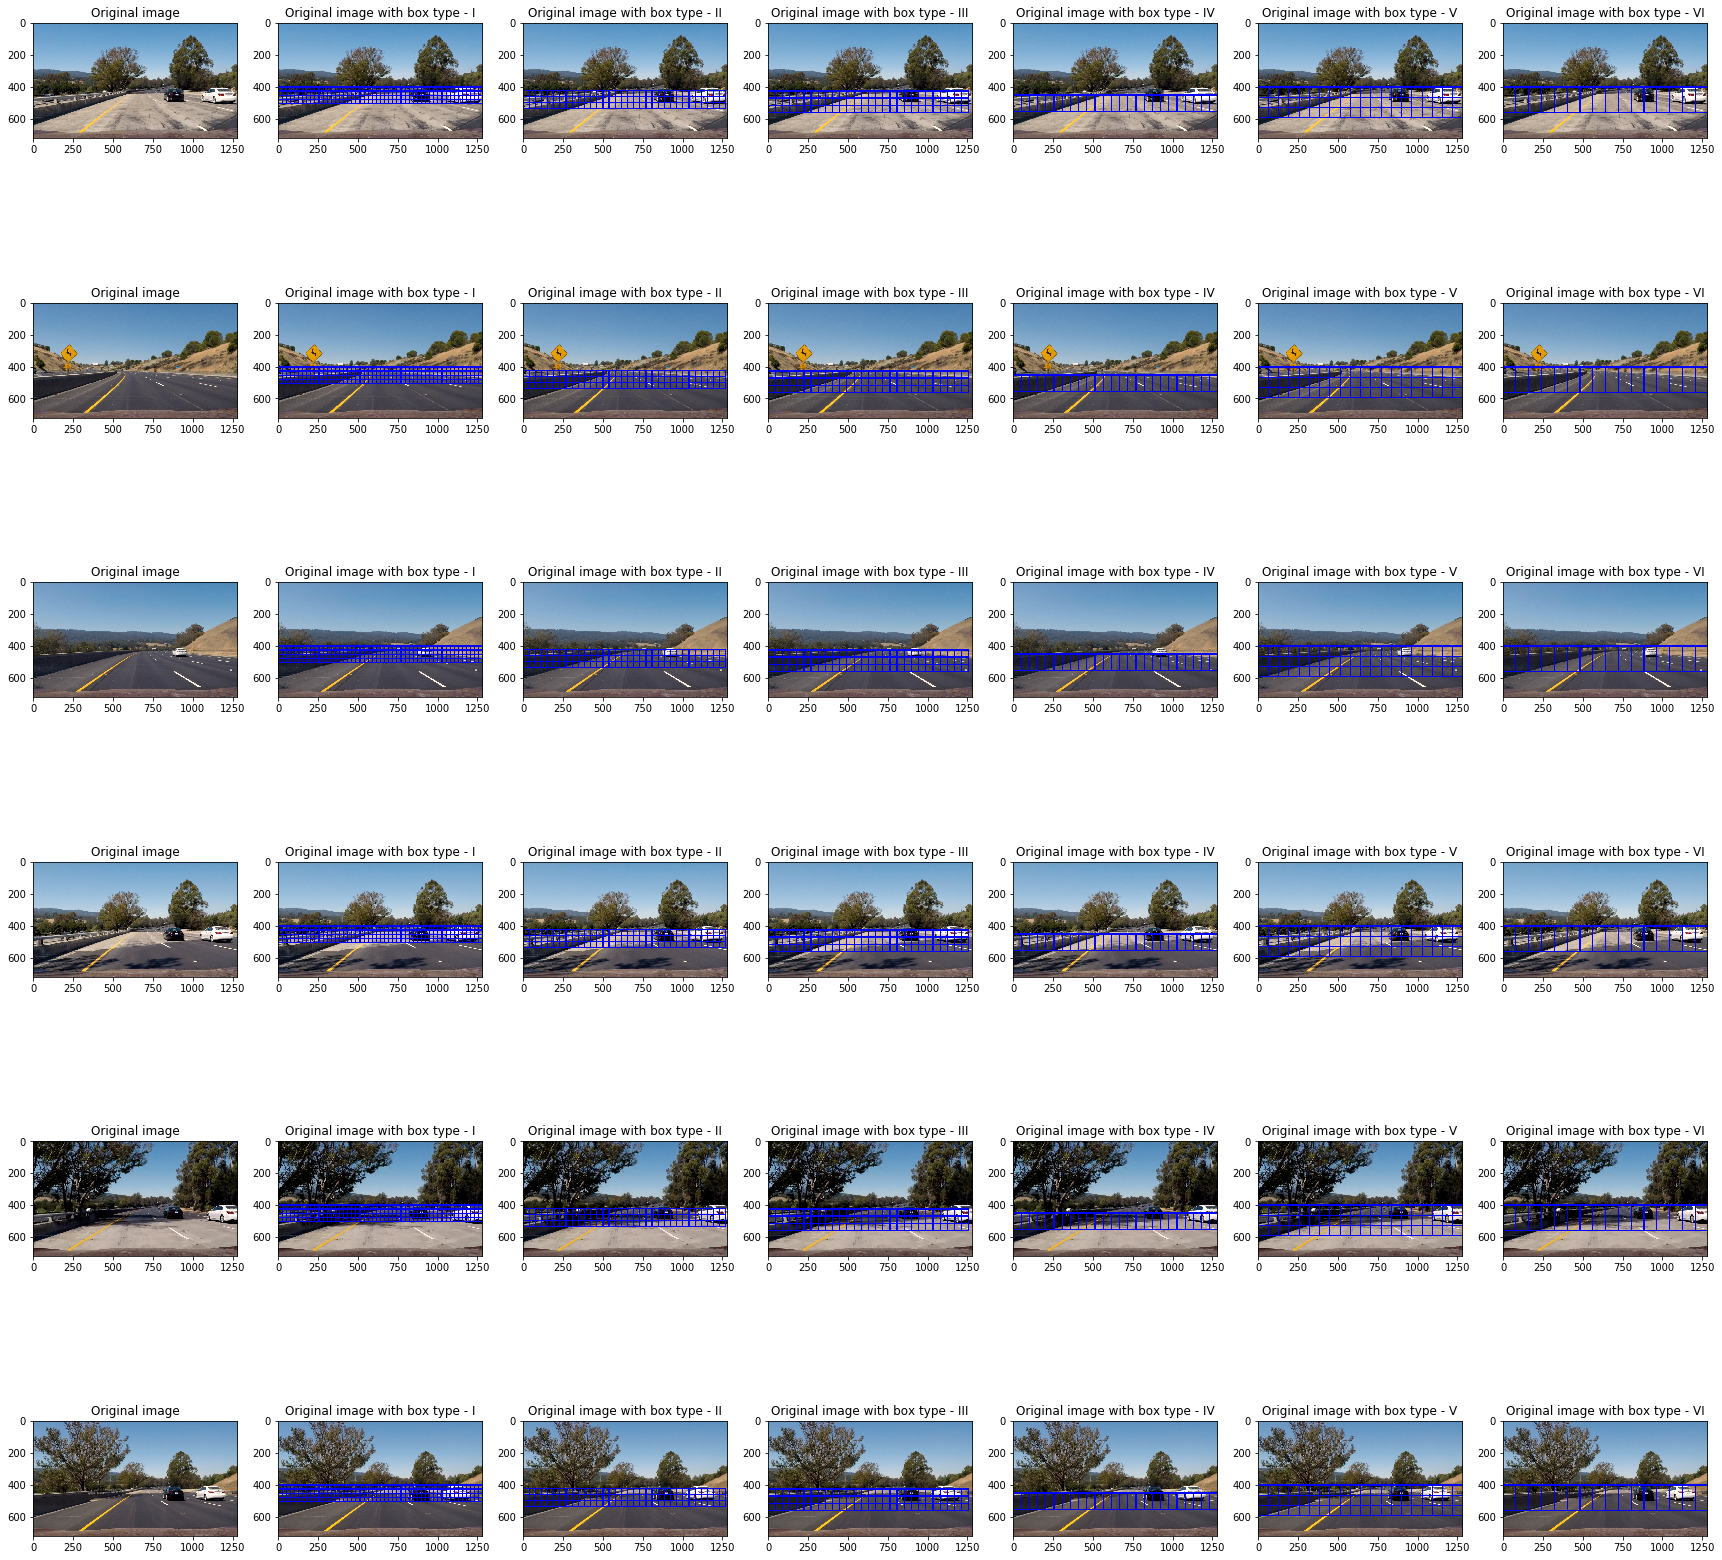

In [6]:
#path = 'C:/Users/AVIK/Documents/Udacity Self Driving Cars/CarND-Vehicle-Detection-master/test_images'
#test_images = glob.glob(path+'/*.jpg')
image_files = os.listdir('test_images')

fig, axs = plt.subplots(6,7, figsize=(30,30))
axs = axs.ravel()

ii = 0
for image_file in image_files:
    image = plt.imread('test_images/' + image_file)
    out_image_file = image_file.split('.')[0] + '.jpg' 
    #image = plt.imread(test_images[ii])
    axs[7*ii].imshow(image)
    axs[7*ii].set_title('Original image')
    draw_img = draw_windows(image, 400, 520, 0.8, pix_per_cell, cell_per_block)
    axs[7*ii+1].imshow(draw_img)
    axs[7*ii+1].set_title('Original image with box type - I')
    draw_img = draw_windows(image, 420, 560, 1.2, pix_per_cell, cell_per_block)
    axs[7*ii+2].imshow(draw_img)
    axs[7*ii+2].set_title('Original image with box type - II')
    draw_img = draw_windows(image, 425, 600, 1.4, pix_per_cell, cell_per_block)
    axs[7*ii+3].imshow(draw_img)
    axs[7*ii+3].set_title('Original image with box type - III')
    draw_img = draw_windows(image, 450, 600, 1.6, pix_per_cell, cell_per_block)
    axs[7*ii+4].imshow(draw_img)
    axs[7*ii+4].set_title('Original image with box type - IV')
    draw_img = draw_windows(image, 400, 600, 2.0, pix_per_cell, cell_per_block)
    axs[7*ii+5].imshow(draw_img)
    axs[7*ii+5].set_title('Original image with box type - V')
    draw_img = draw_windows(image, 400, 600, 2.5, pix_per_cell, cell_per_block)
    axs[7*ii+6].imshow(draw_img)
    axs[7*ii+6].set_title('Original image with box type - VI')
    ii += 1

### Notes
The find_cars function from the lectures 

In [7]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, colorspace, spatial_size=(32, 32), hist_bins=32):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
        
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, colorspace)
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV) ##Hard-coded the colorspace transform.
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    #nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap,b  define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #hog_features = hog_feat1
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            features_stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(features_stacked)    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
                
    return bboxes

### Notes
Choice of bounding boxes type based on the analysis on test images

In [8]:
def vehicle_detect(image):
    overall_boxes = []
    bboxes = find_cars(image, 400, 520, 0.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, colorspace)
    overall_boxes.extend(bboxes)
    bboxes = find_cars(image, 420, 560, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, colorspace)
    overall_boxes.extend(bboxes)
    bboxes = find_cars(image, 425, 600, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, colorspace)###
    overall_boxes.extend(bboxes)
    bboxes = find_cars(image, 450, 600, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, colorspace)
    overall_boxes.extend(bboxes)
    bboxes = find_cars(image, 400, 600, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, colorspace)
    overall_boxes.extend(bboxes)
    bboxes = find_cars(image, 400, 600, 2.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, colorspace)
    overall_boxes.extend(bboxes)
    
    return overall_boxes

### Sliding window
Sliding-window technique as analyzed in earlier cell is used to find/detect/classify cars on the chosen bounding boxes using the trained classifier from other file.
Only region below the horizon with 6 different types of windows,as mentioned above, are chosen for searching vehicles. 

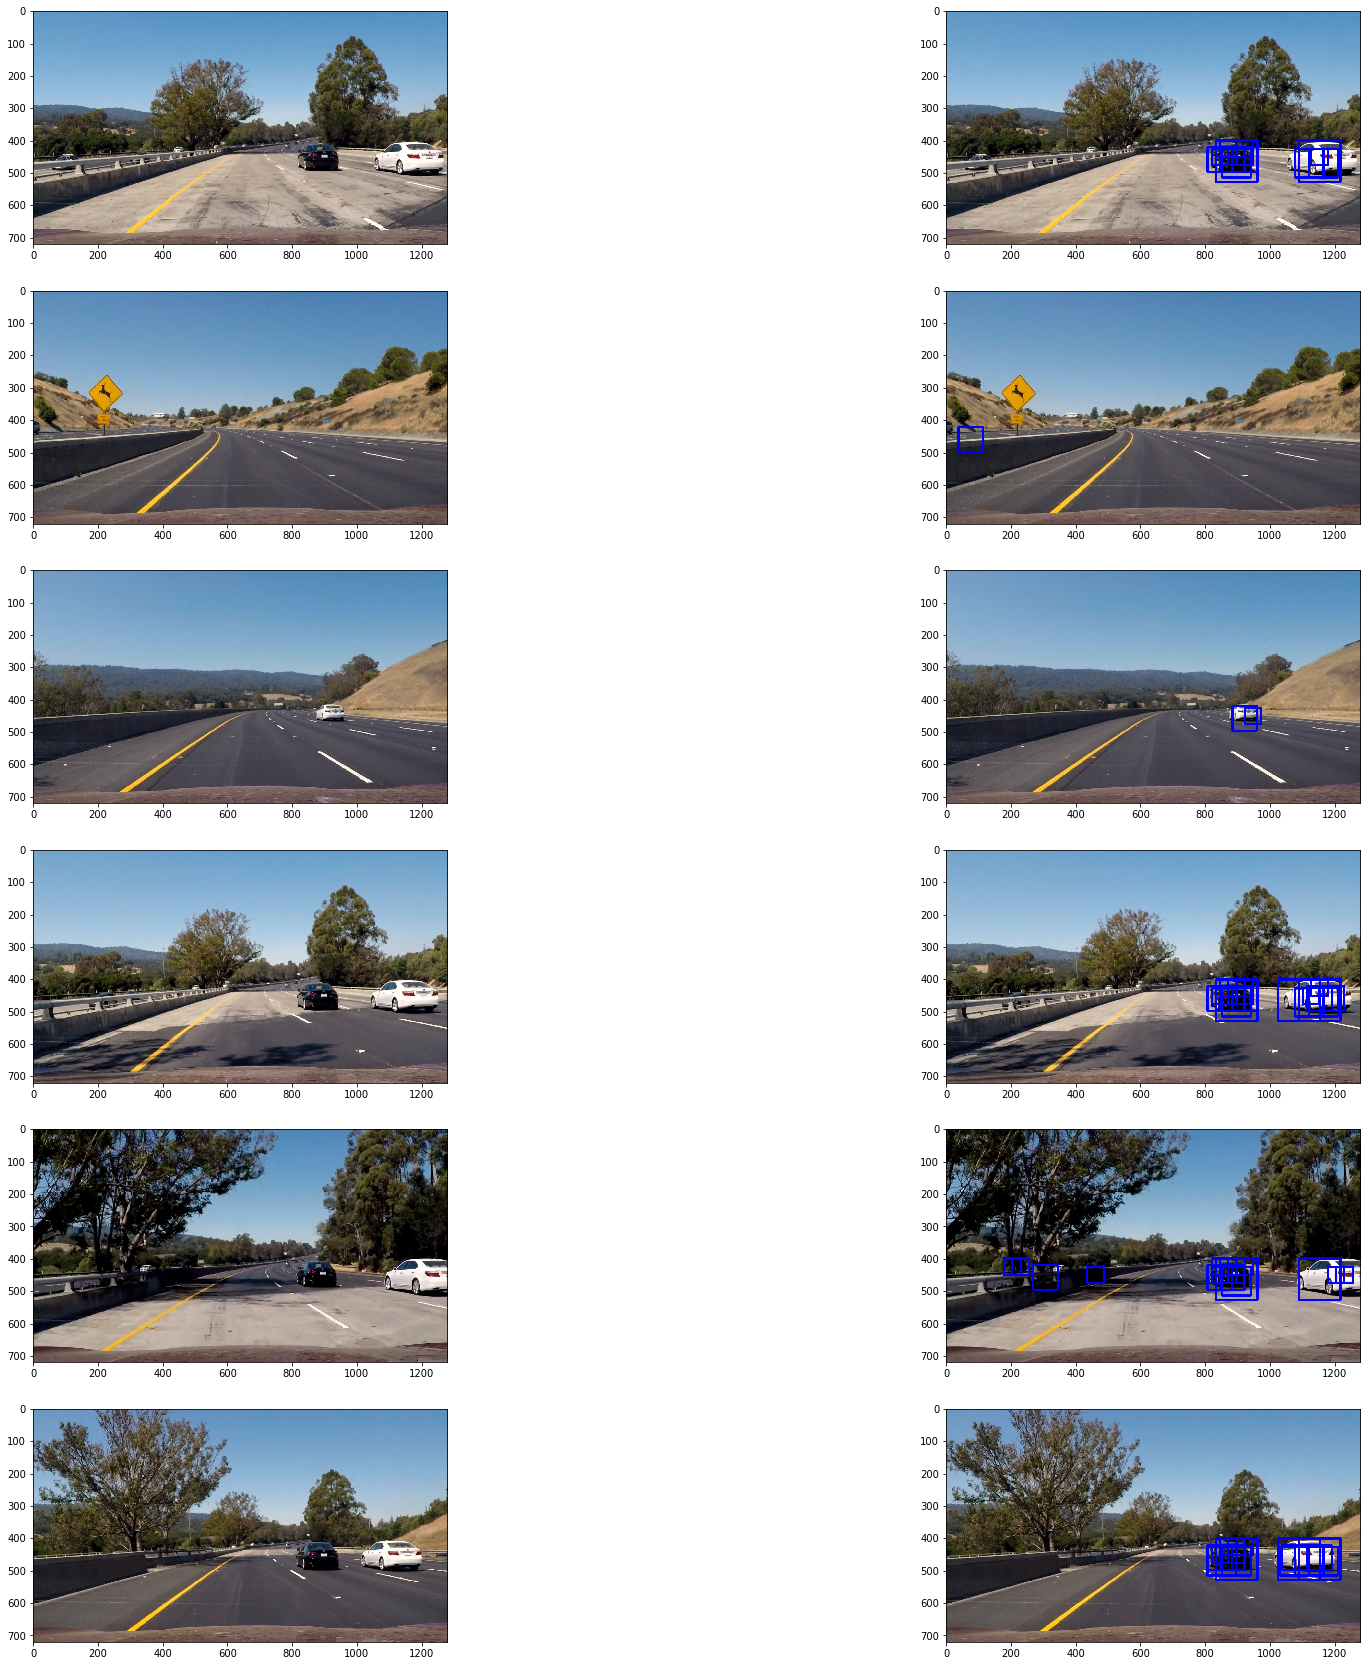

In [9]:
path = 'test_images'
#test_images = glob.glob(path+'/*.jpg')
image_files = os.listdir('test_images')

fig, axs = plt.subplots(len(image_files),2, figsize=(30,30))
axs = axs.ravel()

ii = 0
for image_file in image_files:
    
    image = plt.imread('test_images/'+image_file)
    out_image_file = image_file.split('.')[0] + '.jpg' 
    
    detected_image = np.copy(image)
    axs[2*ii].imshow(image)
    overall_boxes = vehicle_detect(image)
    axs[2*ii+1].imshow(draw_img)
    for jj in range(len(overall_boxes)):
        cv2.rectangle(detected_image,overall_boxes[jj][0],overall_boxes[jj][1],(0,0,255),6) 
    axs[2*ii+1].imshow(detected_image)
    
    if GENERATE_TEST_FIGURES == True:
        fig1 = plt.figure(100+ii)
        plt.imshow(detected_image)
        plt.savefig('output_images/detected_' + out_image_file)
        plt.close(fig1)
        
    ii += 1    

### Heatmaps and Label
After positive detections in each image, the last step is to combine the detections to actually identify vehicle locations and generate the final bounding boxes around the detection, also use thresholding technique to remove potential false alarms.

a) Step 1 - Heatmap and Thresholding - From the test_images, threshold of 2 was chosen 

b) Step 2 - scipy.ndimage.measurements.label() function was used to identify individual blobs in the heatmap.

c) Step 3 - Bouding boxes around each detected clustered boxes were drawn indicated a detected vehicle and its associated position. 


In [10]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,255,255), 6)
    # Return the image
    return img

In [11]:
def get_heatmap(output_image, bboxes):
    threshold = 1
    heat = np.zeros_like(output_image[:,:,0]).astype(np.float)
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    return heatmap

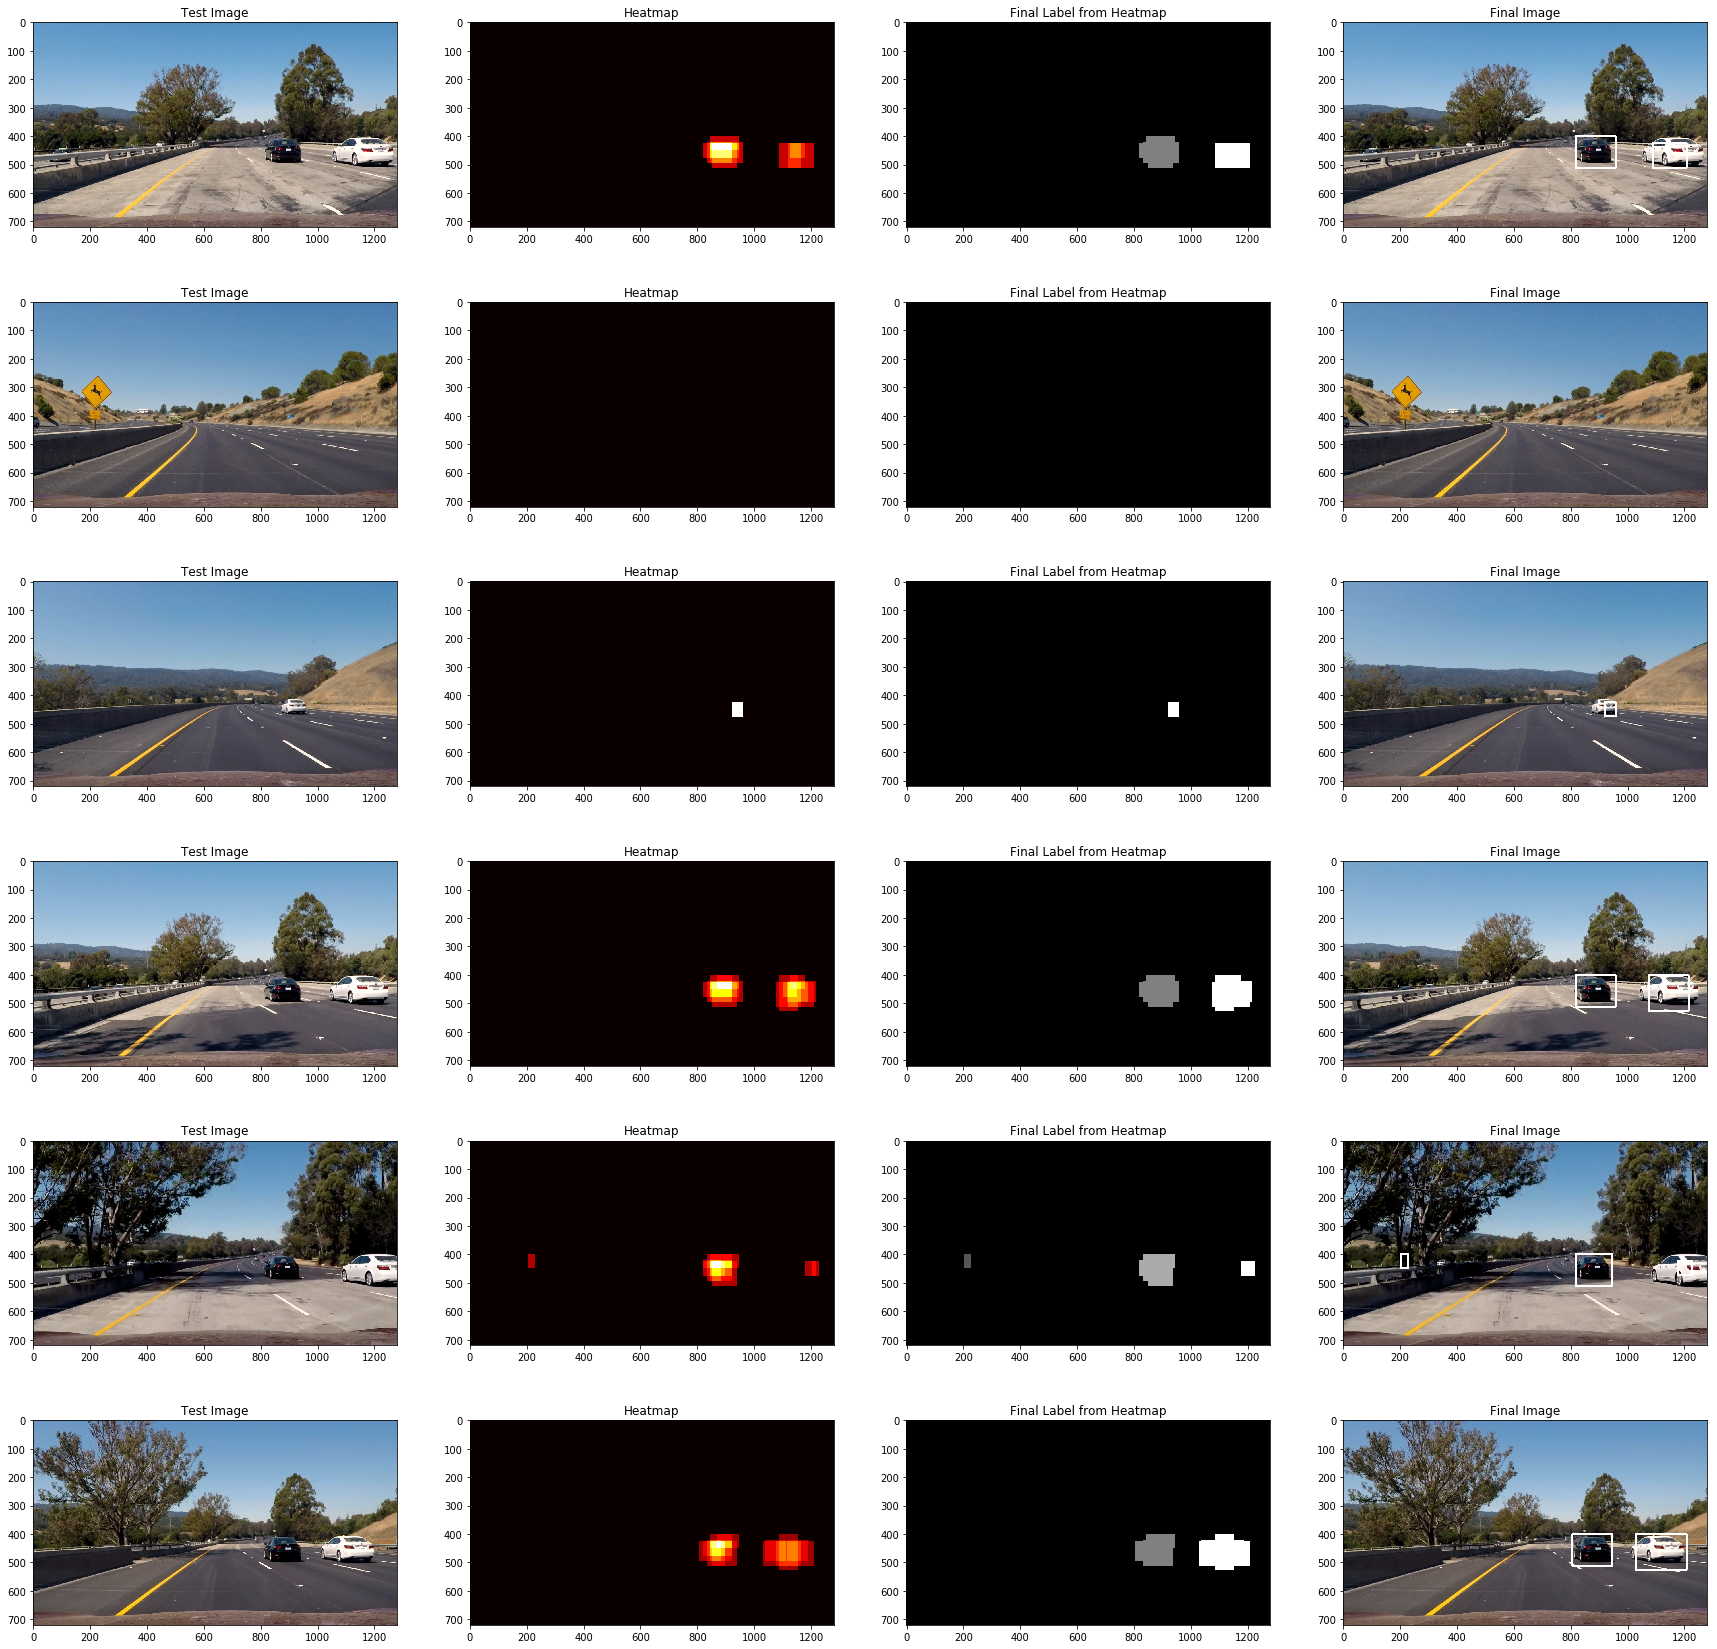

In [12]:
from scipy.ndimage.measurements import label

fig, axs = plt.subplots(6,4, figsize=(30,30))
axs = axs.ravel()

image_files = os.listdir('test_images')
ii = 0
for image_file in image_files:
    
    image = plt.imread('test_images/'+image_file)
    out_image_file = image_file.split('.')[0] + '.jpg' 

    #image = plt.imread(test_images[ii])
    axs[4*ii].imshow(image)
    axs[4*ii].set_title("Test Image")
    overall_boxes = vehicle_detect(image)
    heatmap = get_heatmap(image, overall_boxes)
    axs[4*ii+1].imshow(heatmap, cmap='hot')
    axs[4*ii+1].set_title("Heatmap")
    if GENERATE_TEST_FIGURES == True:
        fig2 = plt.figure(200+ii)
        plt.imshow(heatmap, cmap='hot')
        plt.savefig('output_images/heatmap_' + out_image_file)
        plt.close(fig2)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    axs[4*ii+2].imshow(labels[0], cmap='gray')
    axs[4*ii+2].set_title("Final Label from Heatmap")
    if GENERATE_TEST_FIGURES == True:
        fig3 = plt.figure(300+ii)
        plt.imshow(labels[0], cmap='gray')
        plt.savefig('output_images/labels_' + out_image_file)
        plt.close(fig3)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    axs[4*ii+3].imshow(draw_img)
    axs[4*ii+3].set_title("Final Image")
    if GENERATE_TEST_FIGURES == True:
        fig4 = plt.figure(400+ii)
        plt.imshow(draw_img)
        plt.savefig('output_images/final_image_' + out_image_file)
        plt.close(fig4)
    ii += 1

### Video implementation
For the video, the idea of successive frames having the vehicle in the neighborhood of the present detected vehicle position is used.
Thus a dequeue of 8 is used to remove extraneous false alarms that show up in one frame alone.  

In [13]:
def get_heatmap_video(output_image, bboxes):
    threshold = 2
    heat = np.zeros_like(output_image[:,:,0]).astype(np.float)
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    return heatmap

In [14]:
from collections import deque
history = deque(maxlen = 8)

def detection_pipeline(image):
    overall_boxes = vehicle_detect(image)
    present_heatmap = get_heatmap_video(image, overall_boxes)
    history.append(present_heatmap)

    heatmap = np.zeros_like(present_heatmap).astype(np.float)
    for heat in history:
        heatmap = heatmap + heat

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
     
    return draw_img

In [15]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
video_output = "output_images/test_video_output.mp4"
clip1 = VideoFileClip("test_video.mp4")
clip1_output = clip1.fl_image(detection_pipeline) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/test_video_output.mp4
[MoviePy] Writing video output_images/test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:01<00:01,  1.61s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video_output.mp4 

Wall time: 1min 4s


In [17]:
HTML("""
<video width="900" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [18]:
video_output = "output_images/project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(detection_pipeline) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [35:05<00:01,  1.66s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

Wall time: 35min 8s


In [19]:
HTML("""
<video width="900" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

### Conclusion

At the conclusion, a reasonable pipeline for vehicle detection has been built. Although it has lots of scope for improvements. 

1. There are false alarms in the first few frames since the last 8 frames wasn't filed in the history queue.

2. In practice, vehicles and non-vehicles are imbalanced classes that would appear in a image, using such distribution to sample input data to classifier might be useful.
 
3. More advanced and SoA neural netowrk based architecture such as Yolo and SSD can be used to improve the performance further.